In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from visualizer.main import Visualizer


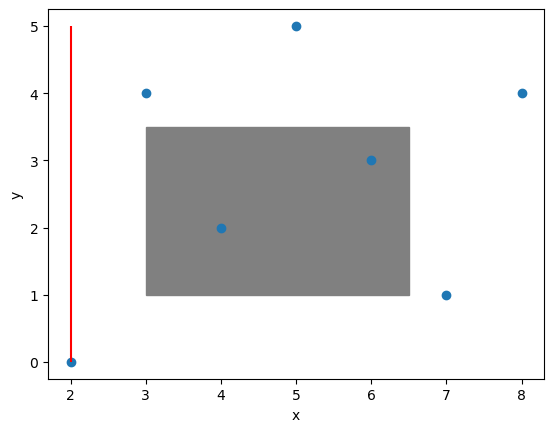

In [35]:
points = [(5,5), (3,4), (6,3), (4,2), (2,0), (7,1), (8,4)]
line=[[(2,0),(2,5)]]
polygon=[(3,1),(3,3.5),(6.5,3.5),(6.5,1)]
vis = Visualizer()
vis.add_polygon(polygon, fill=True, color='grey')

vis.add_point(points)
vis.add_line_segment(line, color='red')
vis.show()

In [36]:
class rect:
    def __init__(self, x_min, x_max, y_min, y_max):
        self.x_min=x_min
        self.x_max=x_max
        self.y_min=y_min
        self.y_max=y_max

    def crossing(self, other):
        return not (
            self.x_max < other.x_min or
            self.x_min > other.x_max or
            self.y_max < other.y_min or
            self.y_min > other.y_max
        )

    def is_inside(self, point):
        x, y = point
        return self.x_min <= x <= self.x_max and self.y_min <= y <= self.y_max
        
        
    def print_rect(self):
        print((self.x_min,self.y_min),(self.x_min,self.y_max),(self.x_max,self.y_max),(self.x_max,self.y_min))

class kd_tree_node:
    def __init__(self, depth, point, rect, left_leaf, right_leaf):
        self.left_leaf=left_leaf
        self.right_leaf=right_leaf
        self.rect=rect
        self.point=point
        self.depth=depth


In [37]:
def partition(A,p,r,b):
    x=A[r][b]
    i=p-1
    for j in range(p,r):
        if A[j][b]<=x:
            i+=1
            A[i],A[j]=A[j],A[i]
    A[i+1],A[r]=A[r],A[i+1]
    return i+1

def quick_select(A,p,r,k,b):
    if p==r: 
        return p
    q=partition(A,p,r,b)
    if q==k:
        return q
    elif k<q:
        return quick_select(A,p,q-1,k,b)
    else:
        return quick_select(A,q+1,r,k,b)

def find_median(A,p,r,b):
    return quick_select(A,p,r,abs((r-p+1)//2)+p,b)

def find_min_max(A):
    x_max,x_min,y_max,y_min=0,float('inf'),0,float('inf')
    
    for element in A:
        x_max=max(x_max,element[0])
        x_min=min(x_min,element[0])
        y_max=max(y_max,element[1])
        y_min=min(y_min,element[1])

    return x_min, x_max, y_min, y_max

(2, 0)


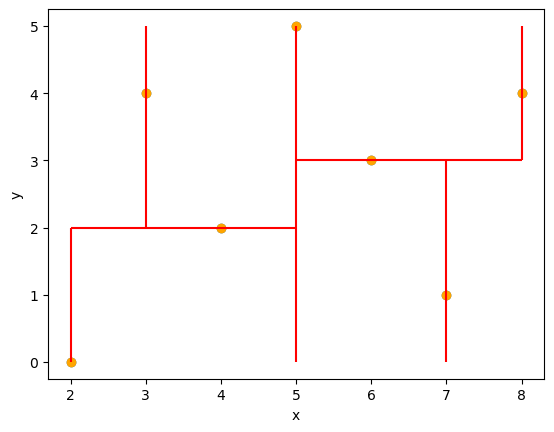

In [43]:
def build_kd_tree_vis(A):
    x_min,x_max,y_min,y_max=find_min_max(A)
    base_rect=rect(x_min,x_max,y_min,y_max)
    base_of_a_tree=kd_tree_node(0,None,base_rect,None,None)
    buildier=base_of_a_tree
    vis = Visualizer()
    vis.add_point(A)

    def build_kd_tree(p,r,tree_node):

        if p>r:
            return None
        elif p==r:
            tree_node.point=p
            b=tree_node.depth%2
            q=p
            tree_node.point=A[q]
            vis.add_point(A[q],color='orange')
            if b:
                vis.add_line_segment([(tree_node.rect.x_max,A[q][b]),(tree_node.rect.x_min,A[q][b])], color='red')
            else:
                vis.add_line_segment([(A[q][b],tree_node.rect.y_max),(A[q][b],tree_node.rect.y_min)], color='red')
            return None
          

        b=tree_node.depth%2
        q=find_median(A,p,r,b)
        tree_node.point=A[q]
        vis.add_point(A[q],color='orange')

        new_tree_left_node=kd_tree_node(tree_node.depth+1,None,None,None,None)
        new_tree_right_node=kd_tree_node(tree_node.depth+1,None,None,None,None)
        tree_node.left_leaf=new_tree_left_node
        tree_node.right_leaf=new_tree_right_node
        
        if b:
            vis.add_line_segment([(tree_node.rect.x_max,A[q][b]),(tree_node.rect.x_min,A[q][b])], color='red')
            new_left_rect=rect(tree_node.rect.x_min,tree_node.rect.x_max,tree_node.rect.y_min,A[q][1])
            new_right_rect=rect(tree_node.rect.x_min,tree_node.rect.x_max,A[q][1],tree_node.rect.y_max)
            new_tree_left_node.rect=new_left_rect
            new_tree_right_node.rect=new_right_rect
            build_kd_tree(p,q-1,new_tree_left_node)
            build_kd_tree(q+1,r,new_tree_right_node)
        else:
            vis.add_line_segment([(A[q][b],tree_node.rect.y_max),(A[q][b],tree_node.rect.y_min)], color='red')
            new_left_rect=rect(tree_node.rect.x_min,A[q][0],tree_node.rect.y_min,tree_node.rect.y_max)
            new_right_rect=rect(A[q][0],tree_node.rect.x_max,tree_node.rect.y_min,tree_node.rect.y_max)
            new_tree_left_node.rect=new_left_rect
            new_tree_right_node.rect=new_right_rect
            build_kd_tree(p,q-1,new_tree_left_node)
            build_kd_tree(q+1,r,new_tree_right_node)

        
        
    build_kd_tree(0,len(A)-1,base_of_a_tree)

    return vis, base_of_a_tree   
vis,base=build_kd_tree(points)
start=base
vis.show()
print(base.left_leaf.left_leaf.point)

In [ ]:
def build_kd_tree(A):
    x_min,x_max,y_min,y_max=find_min_max(A)
    base_rect=rect(x_min,x_max,y_min,y_max)
    base_of_a_tree=kd_tree_node(0,None,base_rect,None,None)
    buildier=base_of_a_tree

    def build_kd_tree(p,r,tree_node):

        if p>r:
            return None
        elif p==r:
            tree_node.point=p
            b=tree_node.depth%2
            q=p
            tree_node.point=A[q]
            return None
          

        b=tree_node.depth%2
        q=find_median(A,p,r,b)
        tree_node.point=A[q]

        new_tree_left_node=kd_tree_node(tree_node.depth+1,None,None,None,None)
        new_tree_right_node=kd_tree_node(tree_node.depth+1,None,None,None,None)
        tree_node.left_leaf=new_tree_left_node
        tree_node.right_leaf=new_tree_right_node
        
        if b:
            new_left_rect=rect(tree_node.rect.x_min,tree_node.rect.x_max,tree_node.rect.y_min,A[q][1])
            new_right_rect=rect(tree_node.rect.x_min,tree_node.rect.x_max,A[q][1],tree_node.rect.y_max)
            new_tree_left_node.rect=new_left_rect
            new_tree_right_node.rect=new_right_rect
            build_kd_tree(p,q-1,new_tree_left_node)
            build_kd_tree(q+1,r,new_tree_right_node)
        else:
            new_left_rect=rect(tree_node.rect.x_min,A[q][0],tree_node.rect.y_min,tree_node.rect.y_max)
            new_right_rect=rect(A[q][0],tree_node.rect.x_max,tree_node.rect.y_min,tree_node.rect.y_max)
            new_tree_left_node.rect=new_left_rect
            new_tree_right_node.rect=new_right_rect
            build_kd_tree(p,q-1,new_tree_left_node)
            build_kd_tree(q+1,r,new_tree_right_node)
            
    build_kd_tree(0,len(A)-1,base_of_a_tree)

    return base_of_a_tree   

In [39]:
def points_inside_rect(rect_section,kd_tree_base):
    start=kd_tree_base
    queue,solution=[],[]
    queue.append(start)
    while len(queue):
        tree_node=queue.pop()
        if rect_section.is_inside(tree_node.point):
            solution.append(tree_node.point)

        if tree_node.left_leaf != None and rect_section.crossing(tree_node.left_leaf.rect):
            queue.append(tree_node.left_leaf)

        if tree_node.right_leaf != None and rect_section.crossing(tree_node.right_leaf.rect):
            queue.append(tree_node.right_leaf)
            
    return solution
        

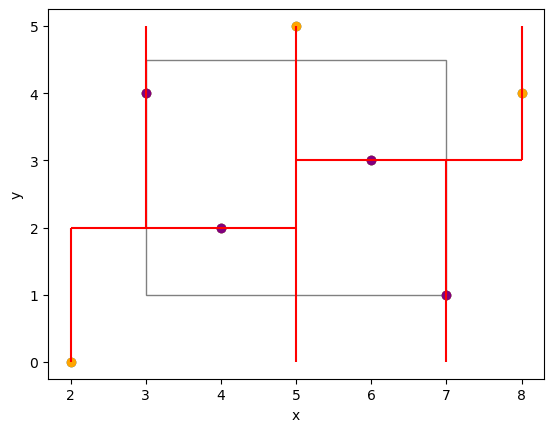

In [45]:
def test_vis(points,section):
    x_min,x_max,y_min,y_max=section
    rect_section=rect(x_min,x_max,y_min,y_max)
    vis,kd_tree_base=build_kd_tree(points)
    polygon=[(x_min,y_min),(x_min,y_max),(x_max,y_max),(x_max,y_min)]
    vis.add_polygon(polygon, fill=False, color='grey')
    solution=points_inside_rect(rect_section,kd_tree_base)
    vis.add_point(solution,color='purple')
    vis.show()
    
section=3,7,1,4.5
test_vis(points,section)

In [46]:
def test(points,section):
    x_min,x_max,y_min,y_max=section
    rect_section=rect(x_min,x_max,y_min,y_max)
    vis,kd_tree_base=build_kd_tree(points)
    polygon=[(x_min,y_min),(x_min,y_max),(x_max,y_max),(x_max,y_min)]
    solution=points_inside_rect(rect_section,kd_tree_base)
    return len(solution)
    
test(points,section)

4